In [1]:
# demo de-noising using fhmm
import sys
sys.path.append("/Users/david/Documents/mastersCode/ubm")
print(sys.path)

['/Users/david/Documents/mastersCode/ubm/final/fhmm', '/Users/david/.conda/envs/ubm/lib/python310.zip', '/Users/david/.conda/envs/ubm/lib/python3.10', '/Users/david/.conda/envs/ubm/lib/python3.10/lib-dynload', '', '/Users/david/.conda/envs/ubm/lib/python3.10/site-packages', '/Users/david/Documents/mastersCode/ubm']


In [2]:
import librosa
import torchaudio
import numpy as np
import config
import os.path
import math
import os
import pathlib
import random
import torch
import utils
import warnings
import my_torch.torchio as tio
import torchaudio.functional as F
import torchaudio.transforms as T

In [3]:
# noise examples
fs = 4000

In [4]:

def noise_file_to_audio(noise_dir, sample_rate):
    effects = [
        ['remix', '1'],  # convert to mono
        ['rate', str(sample_rate)],  # resample
        ['gain', '-n']  # normalises to 0dB
    ]
    noise, sr = torchaudio.sox_effects.apply_effects_file(noise_dir, effects, normalize=True)
    return noise, sr

In [5]:
from whale.setup import get_data, constants, annotations

get_data_whale = get_data.GetDataBase(
    location_of_wav_file=constants.HUMPBACK_WAV_A,
    location_of_annotations=constants.SWOOPS_LABELS_A,
    annotations=annotations.AnnotationsAudacity(),
    window_length=0.025, frame_step=0.01, samples=False, sr=None)

whale_audio, _ = noise_file_to_audio(get_data_whale.location_of_wav_file, 4000)
whale_audio_numpy = whale_audio.numpy().flatten()

In [6]:
# log power seems to work better than magnitude
def get_feature(sample, nfft):
    return np.log(np.square(np.abs(librosa.stft(sample, n_fft=nfft)).T))

In [7]:
# create labels and data
whale_samples = []
whale_features = []
nfft = 256

for i in range(len(get_data_whale.annotations.annotations)):
    annot = get_data_whale.annotations.annotations[i]
    sample = whale_audio_numpy[annot.start:annot.end]
    whale_samples.append(sample)
    whale_features.append(get_feature(sample, nfft))

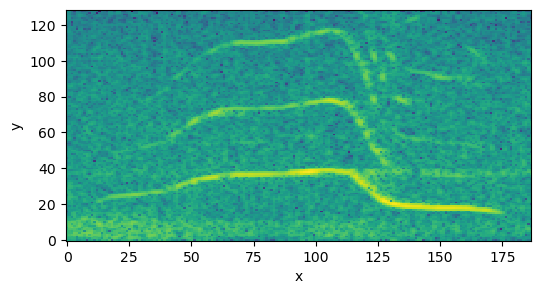

In [8]:
from final.useful import *
from hmmlearn.hmm import GaussianHMM
vis_helper(whale_features[0])
# train hmm
hmm_whale = GaussianHMM(20)

In [9]:
hmm_whale.fit(np.concatenate(whale_features))

GaussianHMM(n_components=20)

In [10]:
# [2] get noise files and update amplitude so snr is correct

noise_files = config.noise_db
noise_files_list = list(pathlib.Path(noise_files).glob('**/*.wav'))
noise_files_list.sort()
transformed_audio, transformed_audio_sr = noise_file_to_audio(noise_files_list[8], fs)
# tio.plot_waveform(transformed_audio)
# tio.plot_specgram(transformed_audio, sample_rate=transformed_audio_sr)
tio.play_audio(transformed_audio, sample_rate=transformed_audio_sr)

In [11]:
# time domain combine
import matplotlib.pyplot as plt
whale_sample = whale_samples[0]
utils.get_average_power(whale_sample, False, False)

0.0019521804219747643

0.0009784079047073359
0.00016643641543994785
10.692715992345587


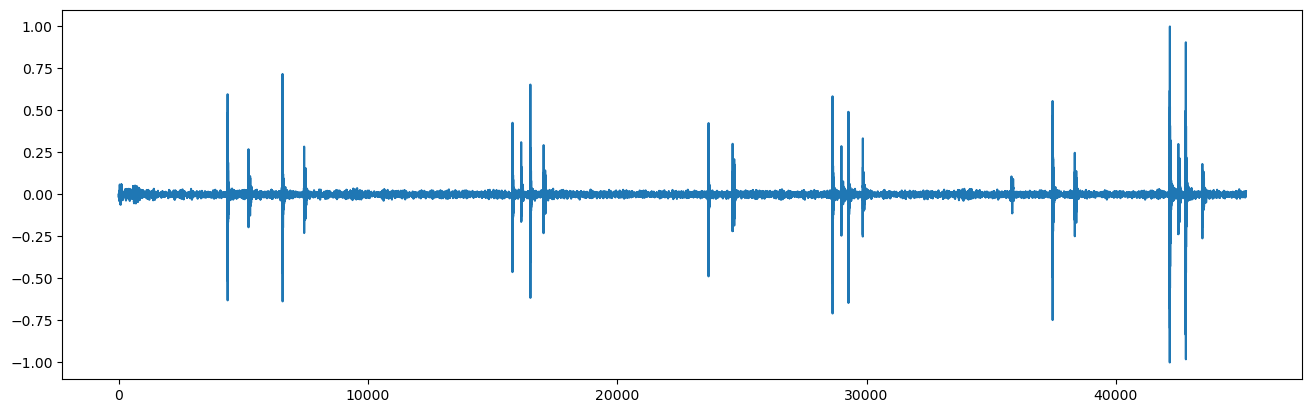

In [12]:
import noisey
# noise features
noise_time = transformed_audio.numpy().flatten()
snr = 3
print(noisey.get_noise_avg_watts(whale_sample, snr))
noise_reduction = 1
print(utils.get_average_power(noise_time[0:len(whale_sample)] * noise_reduction, False, False))
print(utils.snr(whale_sample, noise_time[0:len(whale_sample)] * noise_reduction))
noise_time_reduced = noise_time * noise_reduction
noise_time_reduced = noise_time_reduced[38000:]
plt.plot(noise_time_reduced)

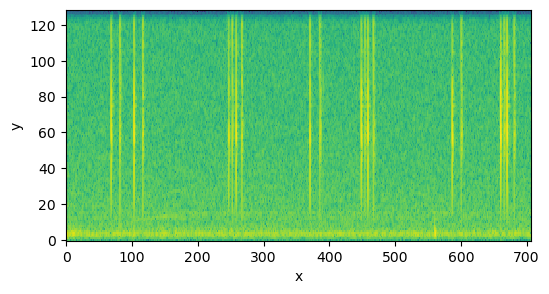

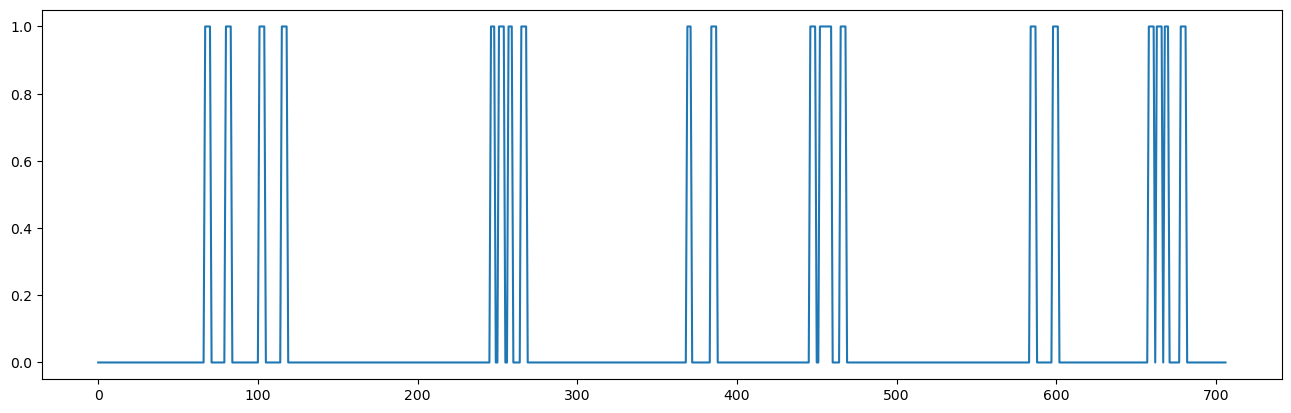

In [13]:
noise_feature = get_feature(noise_time_reduced, nfft)
vis_helper(noise_feature)
hmm_noise = GaussianHMM(2)
hmm_noise.fit(noise_feature)
utils.get_average_power(noise_time_reduced)
_, ss = hmm_noise.decode(noise_feature)
plt.plot(ss)

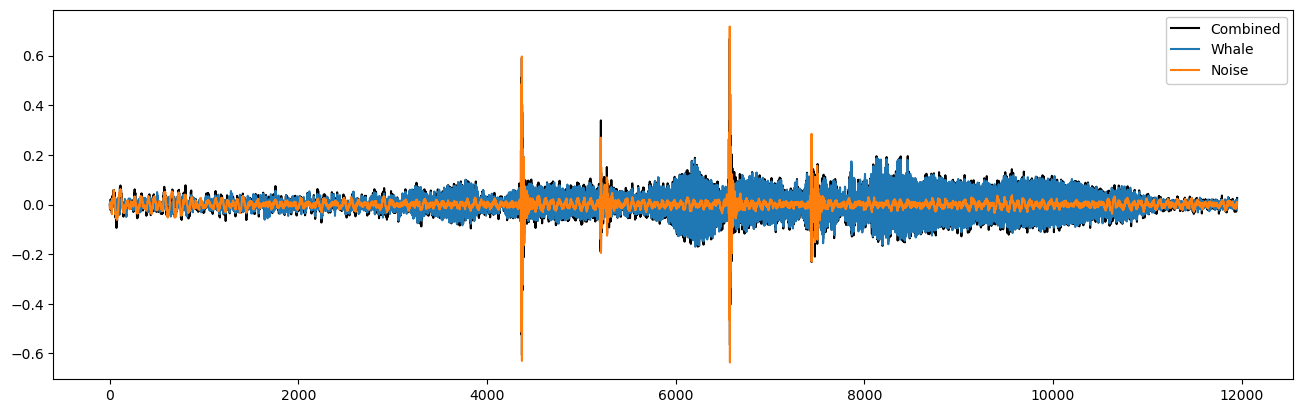

In [14]:
combined_sample_time_domain = whale_sample + noise_time_reduced[0:len(whale_sample)]
plt.plot(combined_sample_time_domain, c='black', label='Combined')
plt.plot(whale_sample, label='Whale')
plt.plot(noise_time_reduced[0:len(whale_sample)], label='Noise')
plt.legend(loc='upper right', facecolor='white',framealpha=1)
# plt.savefig('time-domain-combined')

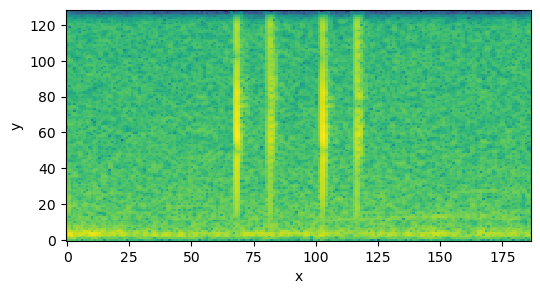

In [15]:

vis_helper(get_feature(noise_time_reduced[0:len(whale_sample)], nfft))

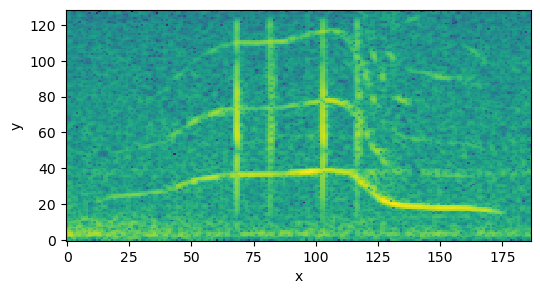

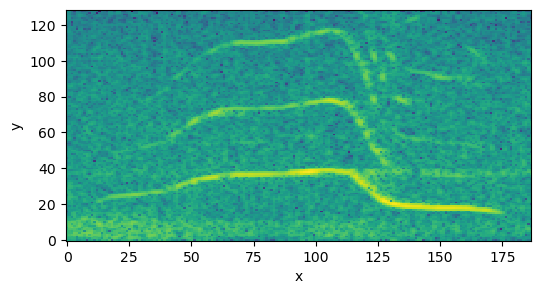

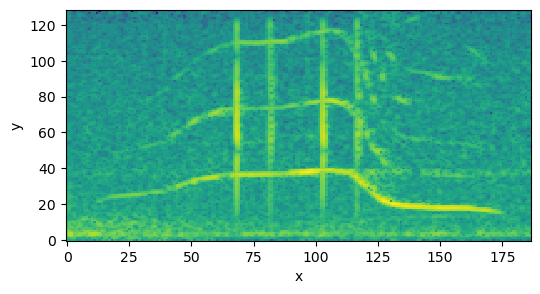

In [16]:
feature_combined = get_feature(combined_sample_time_domain, nfft)
whale_feature = whale_features[0]
vis_helper(feature_combined)
vis_helper(whale_feature)
vis_helper(np.maximum(noise_feature[:whale_feature.shape[0],:], whale_feature))

In [18]:
import hmmUtils
from importlib import reload
reload(hmmUtils)
ViterbiAlgorithmParallel = hmmUtils.doViterbiAlgorithmParallel(feature_combined, hmm_whale, hmm_noise)

KeyboardInterrupt: 

In [33]:
class FactorialHMM:
    def __init__(self, hmm_a: GaussianHMM, hmm_b: GaussianHMM):
        self.hmm_a = hmm_a
        self.hmm_b = hmm_b
        self.n_states_a = hmm_a.n_components
        self.n_states_b = hmm_b.n_components
        self.n_components = self.hmm_a.n_components * self.hmm_b.n_components
        self.n_features = self.hmm_a.n_features

        self.hmm = GaussianHMM(n_components=self.n_components, covariance_type="full")

        transmat = self.get_transmat()
        startprob = self.get_startprob()
        means, covars, states_dict = self.get_m_and_c()
        self.hmm.n_features, self.hmm.means_, self.hmm.transmat_, self.hmm.startprob_ = self.n_features, means, transmat, startprob
        self.hmm.covars_ = np.array([np.diag(i) for i in covars])
        self.states_dict = states_dict

    def decode(self, features):
        log_prob, states_decoded = self.hmm.decode(features)

        ss01 = []
        ss02 = []
        for x in range(len(states_decoded)):
            temp = self.states_dict[states_decoded[x]]
            ss01.append(temp[0])
            ss02.append(temp[1])

        return log_prob, [ss01, ss02]

    def kronecker_list(self, list_A):
        result=list_A[0]
        for i in range(len(list_A)-1):
            result=np.kron(result,list_A[i+1])
        return result

    def get_transmat(self):
        transmat = self.kronecker_list([self.hmm_a.transmat_, self.hmm_b.transmat_]) + 1e-10
        transmat /= transmat.sum(axis=1)
        return transmat

    def get_startprob(self):
        startprob = self.kronecker_list([self.hmm_a.startprob_, self.hmm_b.startprob_]) + 1e-10
        startprob /= startprob.sum(axis=0)
        return startprob

    def get_m_and_c(self):
        states_dict = []
        means = [] # np.zeros((self.n_components, self.n_features))
        covars = [] # np.zeros((self.n_components, self.n_features, self.n_features))
        # logBjk = np.zeros((, states02, T_len))
        for j in range(self.n_states_a):
            m_j = []
            c_j = []
            for k in range(self.n_states_b):
                mean_j = self.hmm_a.means_[j]
                mean_k = self.hmm_b.means_[k]
                m = np.maximum(mean_j, mean_k)
                m_mask = (mean_j > mean_k)
                covar_j = np.diag(self.hmm_a.covars_[j])
                covar_k = np.diag(self.hmm_b.covars_[k])
                c = np.where(m_mask, covar_j, covar_k)
                m_j.append(m)
                c_j.append(c)
                states_dict.append([j, k])
            means.append(m_j)
            covars.append(c_j)

        return np.concatenate(means, axis=0), np.concatenate(covars, axis = 0), states_dict

my_fhmm = FactorialHMM(hmm_whale, hmm_noise)

In [35]:
decode_output = my_fhmm.decode(feature_combined)
whale_output = hmm_whale.decode(feature_combined)

In [40]:
reload(hmmUtils)
# switch to the


p1 = hmmUtils.inputParams(hmm_whale.means_, ViterbiAlgorithmParallel[1][0])
p2 = hmmUtils.inputParams(hmm_noise.means_, ViterbiAlgorithmParallel[1][1])

mask01, mask02 = hmmUtils.weinerFilter.getSoftMask(feature_combined, p1, p2, alpha=1)

whale_recovered = ((np.exp(feature_combined)) * mask01)
noise_recovered = ((np.exp(feature_combined)) * mask02)

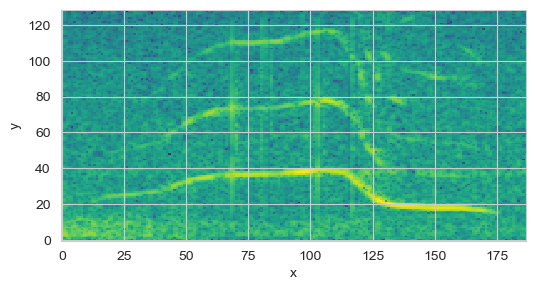

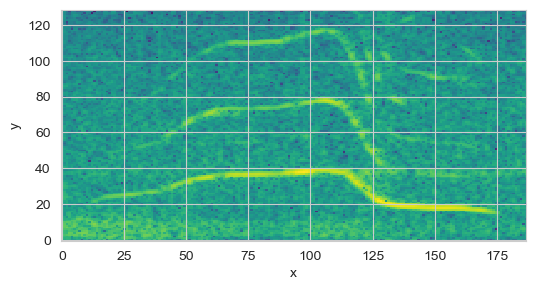

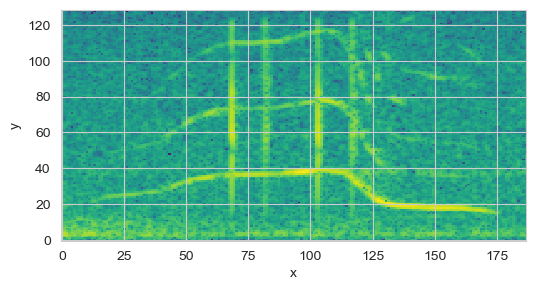

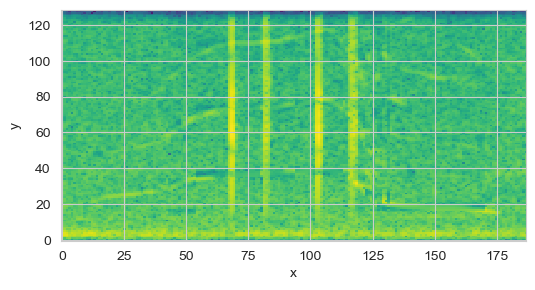

In [41]:
vis_helper(np.log(whale_recovered))
vis_helper(whale_feature)
vis_helper(feature_combined)
vis_helper(np.log(noise_recovered))

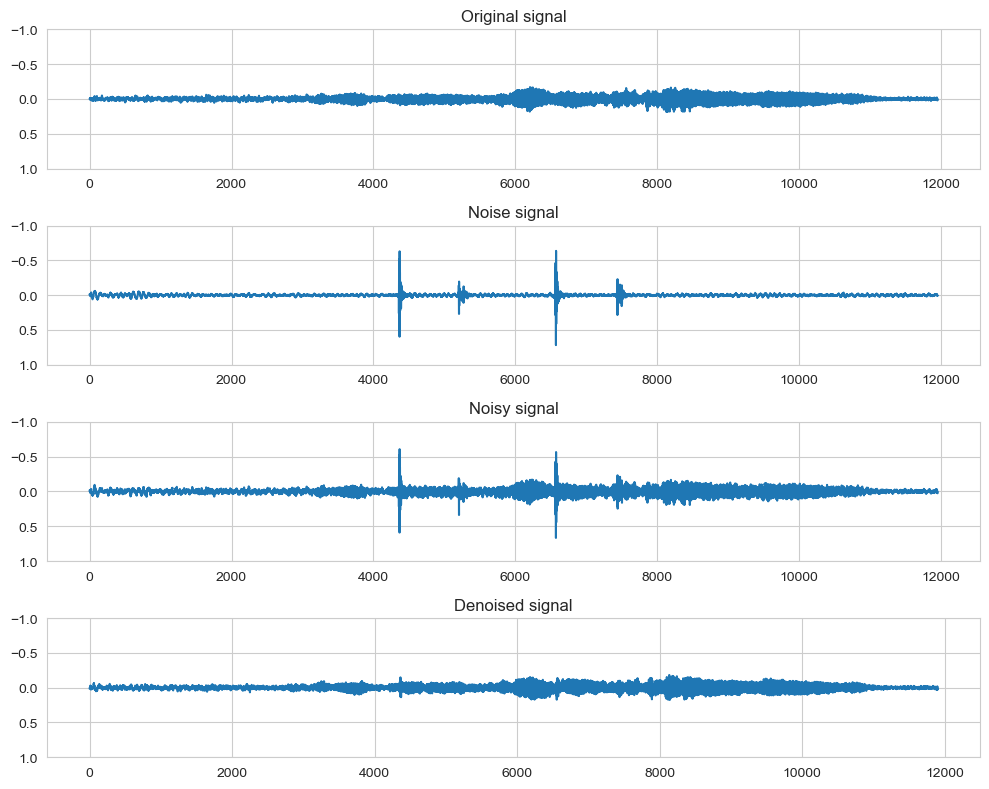

In [66]:
# listen to recovered signal

reload(utils)
ylim = [1, -1]

whale_recovered_stft = np.sqrt(whale_recovered)
whale_recovered_time_domain = librosa.griffinlim(whale_recovered_stft.T, n_fft=nfft)

# Set figure size
fig, axs = plt.subplots(4, 1, figsize=(10, 8))

# Original signal
axs[0].plot(whale_sample)
axs[0].set_title('Original signal')
axs[0].set_ylim(ylim)  # Set y-axis limits

# Noise signal
axs[1].plot(noise_time_reduced[0:len(whale_sample)])
axs[1].set_title('Noise signal')
axs[1].set_ylim(ylim)  # Set y-axis limits

# Noisy signal
axs[2].plot(combined_sample_time_domain)
axs[2].set_title('Noisy signal')
axs[2].set_ylim(ylim)  # Set y-axis limits

# Denoised signal
axs[3].plot(whale_recovered_time_domain)
axs[3].set_title('Denoised signal')
axs[3].set_ylim(ylim)  # Set y-axis limits

# Adjust layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()

import soundfile as sf
sf.write('whale_sample_original.wav', whale_sample, fs , 'PCM_24')
sf.write('whale_sample_combined.wav', combined_sample_time_domain, fs , 'PCM_24')
sf.write('whale_sample_de-noise.wav', whale_recovered_time_domain, fs , 'PCM_24')


In [54]:
from scipy.signal import correlate

def align_signals(original, recovered):
    """
    Align the recovered signal with the original signal using cross-correlation.

    Parameters:
    original (numpy.ndarray): Original signal.
    recovered (numpy.ndarray): Recovered signal.

    Returns:
    numpy.ndarray: Aligned recovered signal.
    """
    # Calculate cross-correlation
    xcorr = correlate(recovered, original, mode='full')

    # Find the index of the maximum correlation
    delay = np.argmax(xcorr) - (len(original) - 1)
    print(delay)

    # Apply the time shift to align the signals
    aligned_recovered = np.roll(recovered, -delay)

    return aligned_recovered

aligned_recovered = align_signals(whale_sample[:len(whale_recovered_time_domain)], whale_recovered_time_domain)


-112


In [55]:
def mean_squared_error(original, recovered):
    """
    Calculate Mean Squared Error (MSE) between two signals.

    Parameters:
    original (numpy.ndarray): Original signal.
    recovered (numpy.ndarray): Recovered signal.

    Returns:
    float: Mean Squared Error.
    """
    if original.shape != recovered.shape:
        raise ValueError("Input signals must have the same shape.")

    mse = np.mean((original - recovered)**2)
    return mse

print(mean_squared_error(whale_sample[:len(whale_recovered_time_domain)], combined_sample_time_domain[:len(whale_recovered_time_domain)]))
print(mean_squared_error(whale_sample[:len(whale_recovered_time_domain)], aligned_recovered))


0.0006811544
0.0024552778533103664


In [ ]:
whale_sample_tensor = torch.from_numpy(whale_sample[np.newaxis, ...])

tio.play_audio(whale_sample_tensor, fs)
tio.play_audio(torch.from_numpy(whale_recovered_time_domain[np.newaxis, ...]), fs)
tio.play_audio(torch.from_numpy(combined_sample_time_domain[np.newaxis, ...]), fs)

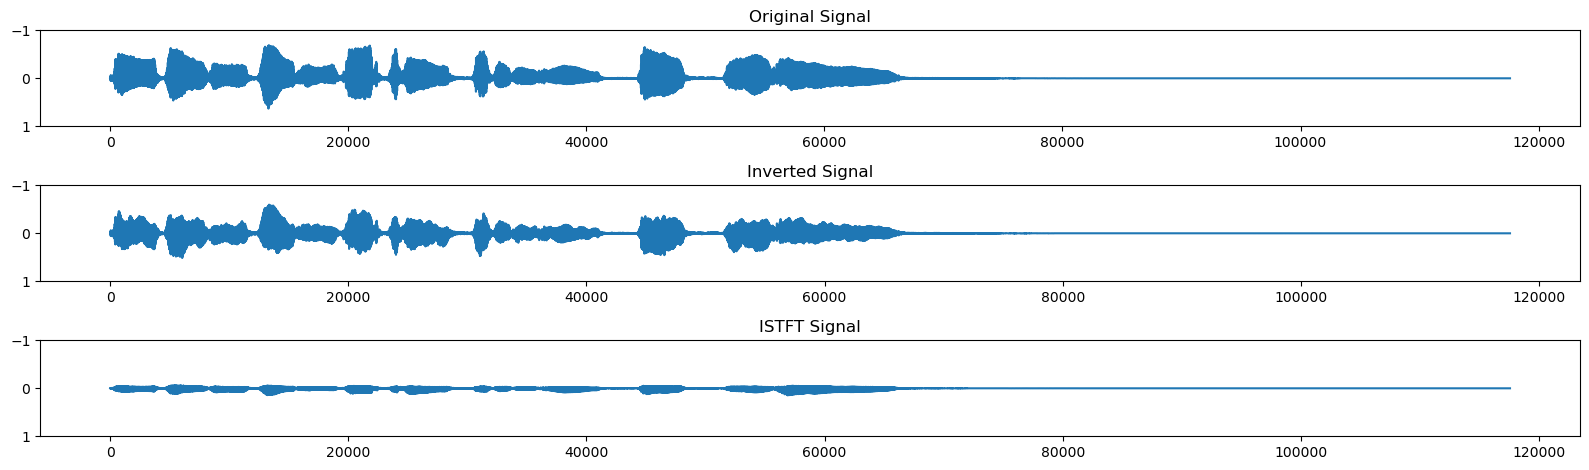

In [123]:
y, sr = librosa.load(librosa.ex('trumpet'))
# Get the magnitude spectrogram
S = np.abs(librosa.stft(y, n_fft=256))
# Invert using Griffin-Lim
y_inv = librosa.griffinlim(S, n_fft=256)
# Invert without estimating phase
y_istft = librosa.istft(S, n_fft=256)


# Plot original signal

import matplotlib.pyplot as plt

plt.subplot(3, 1, 1)
plt.plot(y)
plt.title('Original Signal')
plt.ylim([1,-1])  # Set y-axis limits

# Plot inverted signal
plt.subplot(3, 1, 2)
plt.plot(y_inv)
plt.title('Inverted Signal')
plt.ylim([1,-1])  # Set y-axis limits

# Plot ISTFT signal
plt.subplot(3, 1, 3)
plt.plot(y_istft)
plt.title('ISTFT Signal')
plt.ylim([1,-1])  # Set y-axis limits

# Adjust layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()